<a href="https://colab.research.google.com/github/ajmeek/procgen-tools/blob/paper_graphics/Visualizing_goal_misgeneralization_activations_paper_graphics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf /content/procgen-tools


In [1]:
# try:
#     import procgen_tools
# except ModuleNotFoundError:
#     #commit = '09877d5a9fe0609c2a3792ddda3b45a83ace61f9'
#     #get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/ajmeek/procgen-tools.git@{commit}')
#     pass

get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/ajmeek/procgen-tools.git@paper_graphics')


from procgen_tools.utils import setup

setup() # create directory structure and download data

  Cloning https://github.com/ajmeek/procgen-tools.git (to revision paper_graphics) to /tmp/pip-req-build-gobm5610
  Running command git clone --filter=blob:none --quiet https://github.com/ajmeek/procgen-tools.git /tmp/pip-req-build-gobm5610
  Running command git checkout -b paper_graphics --track origin/paper_graphics
  Switched to a new branch 'paper_graphics'
  Branch 'paper_graphics' set up to track remote branch 'paper_graphics' from 'origin'.
  Resolved https://github.com/ajmeek/procgen-tools.git to commit a1c47e569262cfaf3d03364b75af50c29b3abb02
  Preparing metadata (setup.py) ... done
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


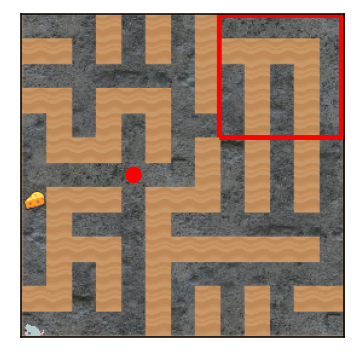

<Figure size 896x672 with 0 Axes>

In [1]:
from procgen_tools.imports import *
from procgen_tools import visualization

# Visualizing details of the goal misgeneralization nets
Let's understand lots of details about [the goal misgeneralization paper](https://arxiv.org/abs/2105.14111).

This network is actually substantially overparameterized. The convolutional layers have a `scale` setting, which is set to 4 in Langosco et al.'s trained networks. `scale` affects how many channels there are at various parts of the net. For example, there are `32*scale` residual channels in the second and third Impala blocks. Training performance and generalization seems similar for `scale=1` and `scale=4`.

# Visualizing actual observation activations

## Code for visualization

In [3]:
from google.colab import output
output.enable_custom_widget_manager()

In [11]:
from procgen_tools.procgen_imports import *

class ActivationsPlotterColab:
    def __init__(self, labels: List[str], plotter: Callable, activ_gen: Callable, hook, coords_enabled: bool=False, defaults : dict = None, save_dir='playground/paper_graphics/visualizations', title: str='', **act_kwargs):
        """
        labels: The labels of the layers to plot
        plotter: A function that takes a label, channel, and activations and plots them
        activ_gen: A function that takes a label and obs and returns the activations which should be sent to plotter
        hook: The hook that contains the activations
        coords_enabled: Whether to enable the row and column sliders
        defaults: A dictionary of default values for the plotter, where the keys are attributes of this class which themselves have the "value" attribute. The class value will be set to the corresponding dictionary value.
        act_kwargs: Keyword arguments to pass to the activations generator
        """
        self.fig = go.Figure()
        self.plotter = plotter
        self.activ_gen = activ_gen
        self.act_kwargs = act_kwargs
        self.hook = hook
        self.save_dir = save_dir
        self.title = title

        #self.fig.layout.title = {'text': self.title}
        self.fig.layout['title'] = {'text': self.title}


        # Remove the _out layer and "embedder." prefixes
        formatted_labels = format_labels(labels)
        print("formatted labels = ", formatted_labels)
        self.label_widget = Dropdown(options=formatted_labels, value=formatted_labels[0], description="Layers")
        self.channel_slider = IntSlider(min=0, max=127, step=1, value=0, description="Channel")

        # Add channel increment and decrement buttons
        button_width = '10px'
        decrement_button, increment_button = [Button(description=descr_str, layout=Layout(width=button_width)) for descr_str in ("-", "+")]
        def add_to_slider(x : int):
            # Clip the value to the min and max
            self.channel_slider.value = np.clip(self.channel_slider.value + x, self.channel_slider.min, self.channel_slider.max)
            self.update_plotter()
        decrement_button.on_click(lambda _: add_to_slider(-1))
        increment_button.on_click(lambda _: add_to_slider(1))
        self.widgets = [self.fig, self.label_widget, HBox([self.channel_slider, decrement_button, increment_button])] # TODO make this a helper for converting arbitrary sliders

        # Add row and column sliders if enabled
        self.coords_enabled = coords_enabled
        if coords_enabled:
            self.col_slider, self.row_slider = (IntSlider(min=0, max=62, step=1, value=32, description="Column"), IntSlider(min=0, max=63, step=1, value=32, description="Row"))
            self.widgets.extend([self.col_slider, self.row_slider])

        # Add a custom filename widget
        self.filename_widget = Text(value="", placeholder="Custom filename", disabled=False)
        self.filename_widget.layout.width = '150px'
        self.button = Button(description="Save image")
        self.button.on_click(self.save_image)
        self.widgets.append(HBox([self.filename_widget, self.button]))

        # Set the default values for the plotter, if provided
        if defaults is not None:
            for key, value in defaults.items():
                getattr(self, key).value = value

        # Ensure that the plot is updated when the widgets are changed
        for widget in self.widgets:
            if widget != self.fig:
                widget.observe(self.update_plotter, names='value')

        # Set the initial plot
        self.update_plotter()

    def display(self):
        """ Display the elements; this function separates functionality from display. """
        print("fig: ", self.fig)
        self.fig.layout['title'] = {'text': self.title}
        display(self.fig)
        display(VBox(self.widgets[1:-1])) # Show a VBox of the label dropdown and the sliders, centered beneath the plot
        display(self.widgets[-1])

    #changed to save in vectorized format - Austin
    def save_image(self, b): # Add a save button to save the image
        basename = self.filename_widget.value if self.filename_widget.value != "" else f"{self.label_widget.value}_{self.channel_slider.value}{f'_{self.col_slider.value}_{self.row_slider.value}' if self.coords_enabled else ''}"
        filepath = f"{self.save_dir}/{basename}.svg"

        # Annotate to the outside of the plot

        old_title = self.fig.layout.title
        #old_title = 'Activations'

        print("old title: ", old_title)


        # if self.title is not '':
        self.fig.layout.title = f"{self.title}"#;\nchannel {self.channel_slider.value}{f' at ({self.col_slider.value}, {self.row_slider.value})' if self.coords_enabled else ''}"
        # else:
        #     self.fig.layout.title = self.title

        self.fig.update_yaxes(autorange="reversed")
        self.fig.write_image(filepath, format='svg')
        print(f"Saved image to {filepath}")

        self.fig.layout.title = old_title # Clear the title
        #self.fig.layout.title = self.title

        self.filename_widget.value = "" # Clear the filename_widget box


    def save_image_func(self, filename: str): # Add a save button to save the image
        #basename = self.filename_widget.value if self.filename_widget.value != "" else f"{self.label_widget.value}_{self.channel_slider.value}{f'_{self.col_slider.value}_{self.row_slider.value}' if self.coords_enabled else ''}"
        filepath = f"{self.save_dir}/{filename}.svg"

        # Annotate to the outside of the plot

        old_title = self.fig.layout.title
        #old_title = 'Activations'

        print("old title: ", old_title)

        bold_title = f'<b>{self.title}</b>'

        # # Add a custom title annotation
        # title_annotation = go.layout.Annotation(
        #     text=bold_title,#self.title,
        #     x=0.5,  # Centered horizontally
        #     y=0.5,  # Centered vertically
        #     xanchor='center',
        #     yanchor='middle',
        #     font=dict(
        #         size=16,   # Customize font size as needed
        #         color='black',  # Customize font color as needed
        #         family='Arial',  # Customize font family as needed
        #     )
        # )

        #self.fig.update_layout(annotations=[title_annotation])


        # if self.title is not '':
        self.fig.layout.title = ""
        #self.fig.layout.title = f"{bold_title}"#;\nchannel {self.channel_slider.value}{f' at ({self.col_slider.value}, {self.row_slider.value})' if self.coords_enabled else ''}"
        # else:
        #     self.fig.layout.title = self.title

        self.fig.update_yaxes(autorange="reversed")
        self.fig.write_image(filepath, format='svg')
        print(f"Saved image to {filepath}")

        self.fig.layout.title = old_title # Clear the title
        #self.fig.layout.title = self.title

        #self.filename_widget.value = "" # Clear the filename_widget box

    def update_plotter(self, b=None):
        """ Update the plot with the current values of the widgets. """
        label = expand_label(self.label_widget.value)
        self.channel_slider.max = models.num_channels(hook=self.hook, layer_name=label) - 1
        channel = self.channel_slider.value = min(self.channel_slider.value, self.channel_slider.max)

        if self.coords_enabled:
            col, row = self.col_slider.value, self.row_slider.value
            activations = self.activ_gen(row, col, label, self.hook, **self.act_kwargs)
        else:
            activations = self.activ_gen(label, self.hook, **self.act_kwargs) # shape is (b, c, h, w) at conv layers, (b, activations) at linear layers

        if len(activations.shape) == 2: # Linear layer (batch, hidden_dim)
            # Ensure shape[1] is a perfect square
            sqrt_act = int(math.sqrt(activations.shape[1]))
            if sqrt_act * sqrt_act == activations.shape[1]:
                activations = np.reshape(activations, newshape=(activations.shape[0], 1, sqrt_act, sqrt_act)) # Make a dummy channel dimension
                # Annotate that there is no spatial meaning to the activations
                self.fig.update_layout(title_text=f"{self.label_widget.value}; reshaped to 2D; no spatial meaning")
            else:
                activations = np.expand_dims(activations, axis=(1,2)) # Add a dummy dimension to the activations

        self.plotter(activations=activations[:, channel], fig=self.fig) # Plot the activations
        format_plotter(fig=self.fig, activations=activations, is_policy_out=self.label_widget.value == 'fc_policy_out', title=self.label_widget.value)

Trying to plot patches below. For now, use the regular code above ^

## Visualization suite
Unfortunately, Colab doesn't support `plotly`'s `FigureWidget` functionality, so live updating of activations won't work here. You can instead configure a level on your copy of the runtime, and then re-render e.g. `channel=55`'s activations by running the lower code block.

To enjoy live editing, clone [our repo](https://github.com/UlisseMini/procgen-tools) and e.g. run the (unfinished) notebook `experiments/visualize_activations.ipynb`.

Thoughts on this.
The patches do not apply the patches to the venv object, which is all that gets passed in to the activation plotter. Can I apply the patches?

Alex's patch plotting function should be fine. Just add another param to the activationsplotter.
Actually I am having some trouble with that. Let me instead try to apply patches to the venv object.

So I can use hook.use_patches(patches) to get a new hook.network (a modified policy). See 437 of patch_utils, where we apply a patch to compare vfields.

In ActivationsPlotter I'm now doing with self.hook.use_patches(patches): etc... to then call the activations func, which is

In [12]:
from procgen_tools import patch_utils

# Note - before running create content/experiments/visualization folder in colab

settings = {'channel_slider': 55, 'label_widget': 'block2.res1.resadd_out'}

print(default_layer)

venv = patch_utils.get_cheese_venv_pair(seed=0)
patches = patch_utils.get_channel_pixel_patch(layer_name='embedder.block2.res1.resadd_out',channel=55, value=5.6, coord=(7,9), default=0.0)
#visualization.plot_patch(patches, hook, bounds=(13,13))

custom_maze_plotter = ActivationsPlotterColab(labels, lambda activations, fig: plot_activations(activations[0], fig=fig), patch_utils.values_from_venv, hook,defaults=settings, title='Activations', venv=venv)

#with hook.use_patches(patches):
#custom_maze_plotter = ActivationsPlotterColabPatches(patches, labels, lambda activations, fig: plot_activations(activations[0], fig=fig), patch_utils.values_from_venv_patched, hook, defaults=settings, venv=venv)
#custom_maze_plotter.display()
custom_maze_plotter.save_image_func(filename='fig_1_part_2')

embedder.block2.res1.resadd_out
formatted labels =  ['block1.conv_in0', 'block1.conv_out', 'block1.maxpool_out', 'block1.res1.relu1_out', 'block1.res1.conv1_out', 'block1.res1.relu2_out', 'block1.res1.conv2_out', 'block1.res1.resadd_out', 'block1.res2.relu1_out', 'block1.res2.conv1_out', 'block1.res2.relu2_out', 'block1.res2.conv2_out', 'block1.res2.resadd_out', 'block2.conv_out', 'block2.maxpool_out', 'block2.res1.relu1_out', 'block2.res1.conv1_out', 'block2.res1.relu2_out', 'block2.res1.conv2_out', 'block2.res1.resadd_out', 'block2.res2.relu1_out', 'block2.res2.conv1_out', 'block2.res2.relu2_out', 'block2.res2.conv2_out', 'block2.res2.resadd_out', 'block3.conv_out', 'block3.maxpool_out', 'block3.res1.relu1_out', 'block3.res1.conv1_out', 'block3.res1.relu2_out', 'block3.res1.conv2_out', 'block3.res1.resadd_out', 'block3.res2.relu1_out', 'block3.res2.conv1_out', 'block3.res2.relu2_out', 'block3.res2.conv2_out', 'block3.res2.resadd_out', 'relu3_out', 'flatten_out', 'fc_out', 'relufc_out

That ^ saves the activations for a specific seed. Unfortunately saving activations after patching is significantly more difficult, and even in the LessWrong post they didn't do that - hence why they had a small image of cheese with a 5.6 over it where they had patched the channel.

Now generate the other images and save them. Then compile together.

In [9]:
venv = patch_utils.get_cheese_venv_pair(seed=0)
patches = patch_utils.get_channel_pixel_patch(layer_name='embedder.block2.res1.resadd_out',channel=55, value=5.6, coord=(7,9), default=0.0)


# TODO - fix the save image directory. I forgot and hardcoded it to a relative path in the repo's scheme
patch_utils.compare_patched_vfields_mpp(venv, patches, hook, render_padding=False, ax_size=6,
                                        original_filename='playground/paper_graphics/visualizations/fig_1_part_1.svg',
                                        patched_filename='playground/paper_graphics/visualizations/fig_1_part_4.svg')

<Figure size 896x672 with 0 Axes>

Now staple this figs together to get fig. 1

In [30]:
!pip install svgutils
!pip install cairosvg
!pip install svgwrite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.4 MB/s eta 0:00:00


In [27]:
import os
import svgutils.transform as sg
from svgutils.compose import Figure, SVG


# Directory containing your separate SVG files
input_directory = "/content/experiments/visualizations"

# Output SVG file
output_svg = "/content/experiments/visualizations/fig_1.svg"

# Get a list of SVG files in the input directory
svg_files = [f for f in os.listdir(input_directory) if f.endswith(".svg")]

print(svg_files)

width = 800
height = 600

# Initialize an empty figure
fig = Figure(width=width, height=height)

# Loop through the SVG files and combine them side by side
x_offset = 0
for svg_file in svg_files:
    # Load the SVG file
    svg_path = os.path.join(input_directory, svg_file)
    svg = SVG(svg_path)

    # Add the loaded SVG to the Figure with a specified offset
    fig.append(svg, x=x_offset, y=0)

    # Update the x-coordinate for the next SVG image
    x_offset += svg.width

# Save the combined SVG image
fig.save(output_svg)

print(f"Combined SVG image saved as {output_svg}")



['fig_1.svg', 'fig_1_part_1.svg', 'fig_1_part_2.svg', 'fig_1_part_4.svg']


AttributeError: ignored

In [29]:
import os
import cairosvg
from io import BytesIO

# Directory containing your separate SVG files
input_directory = "playground/paper_graphics/visualizations"

# Output SVG file
output_svg = "playground/paper_graphics/visualizations/fig_1_cairo.svg"

# Get a list of SVG files in the input directory
svg_files = [f for f in os.listdir(input_directory) if f.endswith(".svg")]

# Initialize a list to store the loaded SVGs
loaded_svgs = []

# Load each SVG file and store it in the list
for svg_file in svg_files:
    svg_path = os.path.join(input_directory, svg_file)
    with open(svg_path, "rb") as svg_file:
        svg_data = svg_file.read()
        loaded_svgs.append(svg_data)

# Create a new SVG by combining the loaded SVGs side by side
combined_svg_data = b'<svg xmlns="http://www.w3.org/2000/svg" width="1000" height="200">'  # Adjust width and height as needed

x_offset = 0
for svg_data in loaded_svgs:
    combined_svg_data += b'<g transform="translate(' + bytes(str(x_offset), "utf-8") + b',0)">' + svg_data + b'</g>'
    x_offset += 200  # Adjust the offset between the SVGs as needed

combined_svg_data += b'</svg>'

# Save the combined SVG image
with open(output_svg, "wb") as output_file:
    output_file.write(combined_svg_data)

print(f"Combined SVG image saved as {output_svg}")

Combined SVG image saved as playground/paper_graphics/visualizations/fig_1_cairo.svg


In [33]:
import os
import svgwrite

# Directory containing your separate SVG files
#input_directory = "path/to/your/svg/files"

# Output SVG file
output_svg = "playground/paper_graphics/visualizations/fig_1_svgwrite.svg"

# Get a list of SVG files in the input directory
#svg_files = [f for f in os.listdir(input_directory) if f.endswith(".svg")]
svg_files = ['playground/paper_graphics/visualizations/fig_1_part_1.svg',
             'playground/paper_graphics/visualizations/fig_1_part_2.svg',
             'playground/paper_graphics/visualizations/fig_1_part_4.svg']

# Create a new SVG drawing
combined_drawing = svgwrite.Drawing(output_svg, profile='tiny', size=('100%', '100%'))

# Initialize x-coordinate for positioning
x_position = 0

# Loop through the SVG files and combine them side by side
for svg_file in svg_files:
    # Load each SVG file
    #svg_path = os.path.join(input_directory, svg_file)

    # Read the content of the SVG file
    with open(svg_file, 'rb') as file:
        svg_content = file.read()

    # Create a new SVG element for the loaded content
    svg_element = svgwrite.parser.parse(svg_content)

    # Add the SVG element to the combined drawing at the specified position
    combined_drawing.add(svg_element).translate(x=x_position)

    # Update the x-coordinate for the next SVG image
    x_position += svg_element['width']

# Save the combined SVG image
combined_drawing.save()
print(f"Combined SVG image saved as {output_svg}")

AttributeError: module 'svgwrite' has no attribute 'parser'

In [37]:
import svgutils.transform as sg

#create new SVG figure
fig = sg.SVGFigure()

# load matpotlib-generated figures
fig1 = sg.fromfile('playground/paper_graphics/visualizations/fig_1_part_1.svg')
fig2 = sg.fromfile('playground/paper_graphics/visualizations/fig_1_part_2.svg')
fig4 = sg.fromfile('playground/paper_graphics/visualizations/fig_1_part_4.svg')

# get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot2.moveto(280, 0, 0.5)
plot4 = fig4.getroot()
plot4.moveto(500, 0)

fig.append([plot2])#, plot2, plot4])

fig.save("playground/paper_graphics/visualizations/fig_1.svg")

In [20]:
from svgutils.compose import *

Figure("160cm", "65cm",
       SVG("playground/paper_graphics/visualizations/fig_1_part_1.svg").scale(0.1),
       SVG("playground/paper_graphics/visualizations/fig_1_part_2.svg"),
       SVG("playground/paper_graphics/visualizations/fig_1_part_4.svg"),
       ).save("playground/paper_graphics/visualizations/fig_1_test.svg")


While I'm still trying to get the above to work, it takes a while on a feedback loop. Let me start below getting the subsidiary figures for the rest of the paper.
Starting with fig 3.